In [17]:
!pip install gurobipy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
def test_heatmap(section_of_elements, grouped_elements, plot_sections = True):
  unique_values = np.unique(section_of_elements)

  if plot_sections:
    unique_values = unique_values[unique_values > 0]  # Exclude zero
  else:
    unique_values = unique_values[unique_values != -1]  # Exclude -1

  palette = sns.color_palette("viridis", len(unique_values))

  # add white color for zero (-1) values
  cmap = mcolors.ListedColormap([(1, 1, 1)] + palette)  # White for zero (-1), then mapped colors

  # mapping of values to color indices
  value_to_color_idx = {val: i+1 for i, val in enumerate(unique_values)}

  if plot_sections:
    value_to_color_idx[0] = 0
  else:
    value_to_color_idx[-1] = 0

  # array values to color indices
  color_indices = np.vectorize(value_to_color_idx.get)(section_of_elements)

  if plot_sections:
    sns.heatmap(np.rot90(section_of_elements), annot=np.rot90(grouped_elements), cmap=cmap,
              linewidths=0.5, linecolor="black", cbar=True)
  else:
    sns.heatmap(np.rot90(section_of_elements), annot=np.rot90(grouped_elements), cmap=cmap,
              linewidths=0.5, linecolor="black", cbar=False)

  if plot_sections:
    plt.title("Section of elements")
  else:
    plt.title("Grouping of elements")
  plt.xlabel("Column")
  plt.ylabel("Level")
  plt.yticks(ticks=np.arange(n_levels), labels=range(n_levels - 1, -1, -1), rotation=0)

  plt.show()

In [19]:
import gurobipy as gp
from gurobipy import GRB

In [ ]:

test_data = [[0,2,2,1,0],[1,1,1,1,0]] #e_ij = 1 if col i exists at level j, bottom to top


n_cols = len(test_data)
n_levels = len(test_data[0])
max_min_groups = 4 #min(n_cols,n_levels) #TODO: NEED NEW HEURISTIC FOR THIS
M = n_levels + 2

Xgcl = [(g,c,l) for l in range(n_levels) for c in range(n_cols) for g in range(max_min_groups)]

S = {(i,j): test_data[i][j] for j in range(n_levels) for i in range(n_cols)}
E = {(i,j): 1 if test_data[i][j] > 0 else 0 for j in range(n_levels) for i in range(n_cols)}
sections = set(l for l in S.values())

# Create a new model
model = gp.Model("Grouping-Optimization")

# # Create variables

x = model.addVars(Xgcl, vtype = GRB.BINARY, name="x")

#marginal_section_cost = 50
marginal_section_cost = [0,20,70]

group_exists = model.addVars(max_min_groups, vtype = GRB.BINARY, name="group")
column_in_group = model.addVars(max_min_groups, n_cols, vtype = GRB.BINARY, name="col_in_group")
level_in_group = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="level_in_group")

# can these be continuous? or must be int?
group_lower_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_lb", lb = 0, ub = n_levels) # upper bound be n_levels-1?
group_upper_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_ub", lb = 0, ub = n_levels)
group_level_range = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_range", lb = 0, ub = n_levels)

#section size variables
#done as binary? or as integer? try both: use worse/better for ablation
group_section = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_section", lb = 0, ub = max(sections))
element_section = model.addVars(S.keys(), vtype=GRB.INTEGER, name="element_section", lb=0, ub = max(sections))
# binary variables y[i,j,k] that are 1 if element_section[i,j] == k
y = model.addVars(S.keys(), range(len(marginal_section_cost)), vtype=GRB.BINARY, name="y")

# cost variables for element_section
cost_section = model.addVars(S.keys(), vtype=GRB.CONTINUOUS, name="cost_section")

# Ensure each element_section[i,j] has exactly one assigned level
# Zs = model.addVars(Xgcl, vtype = GRB.BINARY, name = "Zs") #if group section = element section

#each group is same section
#group section has to be >= section of element
#take min of cost_of_section * num of elements with that section
#^either count # of sections in each group, and linearize cost_of_section var * # sections
#that is for integer version, binary version has binary var for which section a grou phas, times its cost, times number of elements
# or has bin var for section of each element, and multiple by cost of that section.
# 4 variations??
M_sections = max(sections)+1

Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zu")
Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zl")

In [21]:
for c in range(n_cols):
  for l in range(n_levels):
    #sum of Xgcl over all groups must = if col at that level exists
    model.addConstr(gp.quicksum(x[g,c,l] for g in range(max_min_groups)) == E[c,l])
    model.addConstr(element_section[c,l] >= S[c,l])

for g in range(max_min_groups):
  #range of group g = upper bound - lower bound
  model.addConstr(group_level_range[g] == group_upper_bound[g] - group_lower_bound[g])

  for c in range(n_cols):
    for l in range(n_levels):

      #if element is in a group, it's section is at least the group's
      #if not in the group, it's greater than (at most) 0
      model.addConstr(element_section[c,l] >= group_section[g] - M_sections*(1-x[g,c,l]))
      model.addConstr(element_section[c,l] <= group_section[g] + M_sections*(1-x[g,c,l]))

      #if element is in group, that column is in the group
      model.addConstr(column_in_group[g,c] >= x[g,c,l])

      #if element is in group, that level is in the group
      model.addConstr(level_in_group[g,l] >= x[g,c,l])

      #if element is in that group, that group exists
      model.addConstr(group_exists[g] >= x[g,c,l])

for g in range(max_min_groups):
  for l in range(n_levels):

    #calculate upper, lower level
    #NOTE: need to min(Ug) and max(Lg) for this to work
    #NOTE: in julia, everything is 1 based, might need to adjust formulation to make everything work as 0-based
    model.addConstr(l*level_in_group[g,l] <= group_upper_bound[g])
    model.addConstr(l*level_in_group[g,l] + M*(1-level_in_group[g,l]) >= group_lower_bound[g])

    #set Zl
    model.addConstr(M*Zl[g,l] >= l-group_lower_bound[g]+1)
    model.addConstr(M*(1-Zl[g,l]) >= group_lower_bound[g]-l)

    #set Zu
    model.addConstr(M*Zu[g,l] >= group_upper_bound[g]-l+1)
    model.addConstr(M*(1-Zu[g,l]) >= l-group_upper_bound[g])

    #if a level is within lower/upper bound, it's in the group
    # to add the following as lazy constraint (not now)
    model.addConstr(1+level_in_group[g,l] >= Zu[g,l]+Zl[g,l])

    # for c in range(n_cols):
    # #   #if column and level are in the group, so is the element
    # #   #todo: lazily constraint??
    #   model.addConstr(column_in_group[g,c]+level_in_group[g,l] <= 1 + x[g,c,l])

for i, j in S.keys():
    model.addConstr(gp.quicksum(y[i, j, k] for k in range(len(marginal_section_cost))) == 1)

    for k in range(len(marginal_section_cost)):
        model.addConstr((y[i, j, k] == 1) >> (element_section[i, j] == k))  # Enforce correct index
        model.addConstr((y[i, j, k] == 1) >> (cost_section[i, j] == marginal_section_cost[k]))

In [22]:
def lazy_callback(model, where):
    if where == GRB.Callback.MIPSOL:  # Check if a new solution is found
        # Retrieve the values of decision variables at the current solution
        column_vals = model.cbGetSolution(column_in_group)
        level_vals = model.cbGetSolution(level_in_group)
        x_vals = model.cbGetSolution(x)

        # Iterate through indices and add violated constraints
        for g in range(max_min_groups):
            for l in range(n_levels):
                for c in range(n_cols):
                    lhs = column_vals[g, c] + level_vals[g, l]  # Left-hand side
                    rhs = 1 + x_vals[g, c, l]  # Right-hand side
                    if lhs > rhs + 1e-6:  # Constraint is violated
                        model.cbLazy(column_in_group[g, c] + level_in_group[g, l] <= 1 + x[g, c, l])

In [23]:
model.setObjective(gp.quicksum(cost_section[i, j] for i, j in S.keys()) + 100*gp.quicksum(group_exists),GRB.MINIMIZE)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_25324\2140531940.py:1: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective(gp.quicksum(cost_section[i, j] for i, j in S.keys()) + 100*gp.quicksum(group_exists),GRB.MINIMIZE)


In [24]:
# model.write("group-optim-toy.lp")

# Optimize model
model.Params.LazyConstraints = 1

model.optimize(lazy_callback)

#model.optimize()

if model.status == GRB.OPTIMAL or model.status == GRB.SUBOPTIMAL:
  for v in model.getVars():
      if v.X > 0.5:
          print(f"{v.VarName}, {v.x:g}") #{v.X:g}")

  print(f"Obj: {model.ObjVal:g}")
  print(f"Time: {model.Runtime:g}")
else:
  print(f"Optimization failed with status: {model.status}")

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600G with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
LazyConstraints  1

Optimize a model with 374 rows, 178 columns and 868 nonzeros
Model fingerprint: 0x67f0dfca
Model has 60 simple general constraints
  60 INDICATOR
Variable types: 10 continuous, 168 integer (142 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 1e+01]
  GenCon rhs range [1e+00, 7e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 96 rows and 44 columns
Presolve time: 0.01s
Presolved: 278 rows, 134 columns, 731 nonzeros
Presolved model has 9 SOS constraint(s)
Variable types: 9 continuous, 125 integer (106 binary)
Found heuristic solution: objective 7

In [25]:
import numpy as np

grouped_elements = np.full((n_cols, n_levels), -1)  # -1 as default (if element doesn't exist)

for g, i, j in x.keys():
    if x[g, i, j].X > 0.5:  # Check if x[g, i, j] is active
        grouped_elements[i, j] = g

print(grouped_elements)

[[-1  3  3  3 -1]
 [ 2  2  2  2 -1]]


In [26]:
section_of_elements = np.full((n_cols, n_levels), 0)

for i, j in element_section.keys():
    section_of_elements[i, j] = element_section[i, j].X

print(section_of_elements)

[[0 2 2 2 0]
 [1 1 1 1 0]]


In [27]:
# two heatmaps: one: color for representing groups and number representing the group section and vice versa
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_heatmap(grouped_elements, section_of_elements, plot_sections = False):
  unique_vals = np.unique(grouped_elements)

  if plot_sections:
    unique_vals = unique_vals[unique_vals > 0]
    section_of_elements = np.where(section_of_elements == -1, 0, section_of_elements)
  else:
    unique_vals = unique_vals[unique_vals != -1]

  print(section_of_elements)

  rotated_grouped_elements = np.rot90(grouped_elements, k=1)

  rotated_section_of_elements = np.rot90(section_of_elements, k=1)

  num_classes = len(unique_vals)  # Number of unique values (excluding -1)
  colors = sns.color_palette("tab10", num_classes)  # Get distinct colors
  colors = [(1, 1, 1)] + colors  # white color for -1
  #colors[0] = [(1, 1, 1)]  # white color for -1
  print(colors)
  cmap = mcolors.ListedColormap(colors)
  print(cmap)

  bounds = np.arange(-1, num_classes + 1) - 0.5
  norm = mcolors.BoundaryNorm(bounds, cmap.N)

  print(rotated_grouped_elements)

  plt.figure(figsize=(6, 5))
  sns.heatmap(rotated_grouped_elements, cmap=cmap, norm=norm, linewidths=0.5,
              linecolor='black', annot=rotated_section_of_elements, cbar=False)

  plt.title("Grouping of elements")
  plt.xlabel("Column")
  plt.ylabel("Level")
  plt.yticks(ticks=np.arange(n_levels), labels=range(n_levels - 1, -1, -1), rotation=0)

  plt.show()

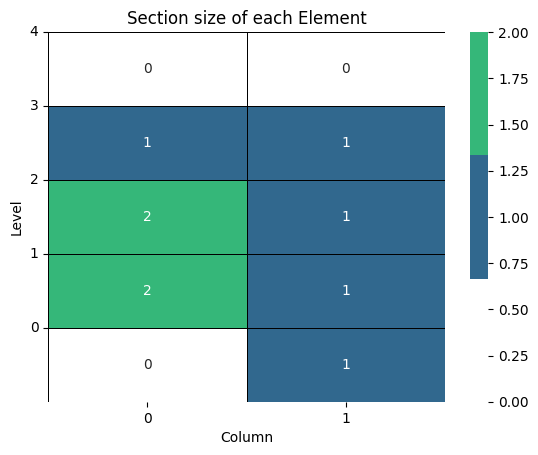

In [28]:
test_data_rotated = np.rot90(np.array(test_data), k=1)

unique_values = np.unique(test_data_rotated)
unique_values = unique_values[unique_values > 0]

palette = sns.color_palette("viridis", len(unique_values))

cmap = mcolors.ListedColormap([(1, 1, 1)] + palette)

value_to_color_idx = {val: i+1 for i, val in enumerate(unique_values)}
value_to_color_idx[0] = 0

color_indices = np.vectorize(value_to_color_idx.get)(test_data_rotated)

sns.heatmap(test_data_rotated, annot=True, cmap=cmap,
            linewidths=0.5, linecolor="black", cbar=True)

plt.title("Section size of each Element")
plt.xlabel("Column")
plt.ylabel("Level")
plt.yticks(ticks=np.arange(n_levels), labels=range(n_levels - 1, -1, -1), rotation=0)

plt.show()

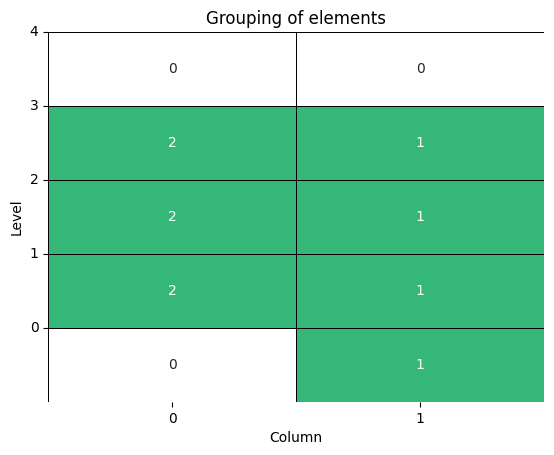

In [29]:
test_heatmap(grouped_elements, section_of_elements, False)

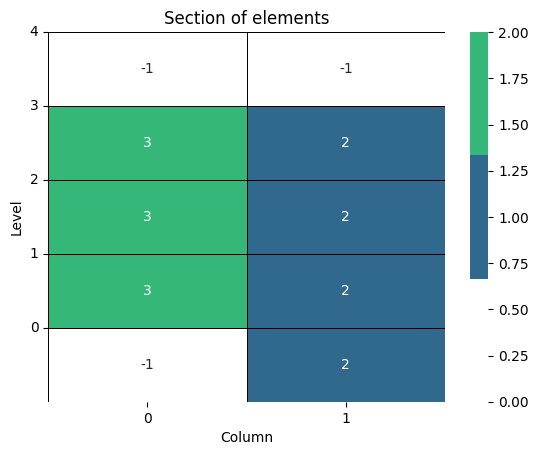

In [30]:
test_heatmap(section_of_elements, grouped_elements)